# NYC taxi trip duration prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [2]:
df=pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
df.shape

(729322, 11)

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [5]:
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

* No missing values.

In [6]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [7]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [8]:
df['pickup_dayofweek']=df['pickup_datetime'].dt.dayofweek
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['pickup_dayofmonth']=df['pickup_datetime'].dt.day

In [9]:
#Let's derive distance of trip
import haversine

#haversine.haversine((-73.953918,40.778873),(73.963875,40.771164), unit=haversine.Unit.METERS)
df['distance']=df.apply(lambda x: haversine.haversine((x['pickup_longitude'],x['pickup_latitude']),(x['dropoff_longitude'],x['dropoff_latitude'])), axis=1)

In [10]:
df.drop(['id','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime','dropoff_datetime'], axis=1, inplace=True)

In [11]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'pickup_dayofweek', 'pickup_hour', 'pickup_month', 'pickup_dayofmonth',
       'distance'],
      dtype='object')

In [12]:
df.trip_duration.quantile(.97), df.trip_duration.min(), df.trip_duration.max()

(2491.0, 1, 1939736)

In [13]:
df.distance.quantile(.99), df.distance.min(), df.distance.max()

(22.53550477057342, 0.0, 662.8145584924454)

* there are outlier values which can be dropped

In [14]:
df.drop(df[(df.trip_duration < 20)|(df.trip_duration > 2500)].index, axis=0, inplace=True)

In [15]:
df.drop(df[(df.distance==0) | (df.distance>20)].index,axis=0, inplace=True)

<AxesSubplot:xlabel='pickup_hour', ylabel='trip_duration'>

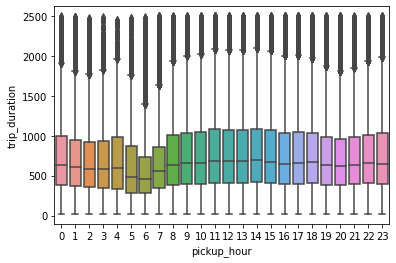

In [16]:
sns.boxplot(data=df, x='pickup_hour',y='trip_duration')

* Let's create time windows as the variation is not significat across every year

In [16]:
df['window']=pd.cut(df['pickup_hour'],[0,8,18,23], labels=['non-busy','busy','non-busy'],ordered=False)
df.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,pickup_dayofweek,pickup_hour,pickup_month,pickup_dayofmonth,distance,window
0,2,1,N,400,0,16,2,29,1.132157,busy
1,1,2,N,1100,4,23,3,11,1.336773,non-busy
2,2,2,N,1635,6,17,2,21,5.720824,busy
3,2,6,N,1141,1,9,1,5,0.841675,busy
4,1,1,N,848,2,6,2,17,3.365350,non-busy


<AxesSubplot:xlabel='pickup_dayofweek', ylabel='trip_duration'>

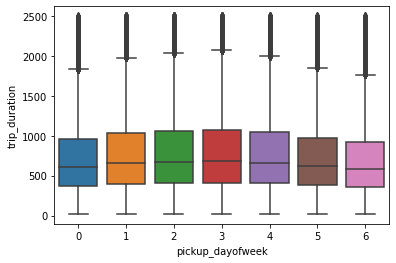

In [18]:
sns.boxplot(data=df, x='pickup_dayofweek',y='trip_duration')

* let's divide day of week into on and off based on average trip duration

In [17]:
df['typeofday']=df['pickup_dayofweek'].map({0:'off',1:'on',2:'on',3:'on',4:'on',5:'off',6:'off'})

In [18]:
# Let's drop hour and dayofweek as we have created a separate column to depict this info
df.drop(['pickup_hour','pickup_dayofweek'], axis=1, inplace=True)

<AxesSubplot:xlabel='distance', ylabel='Density'>

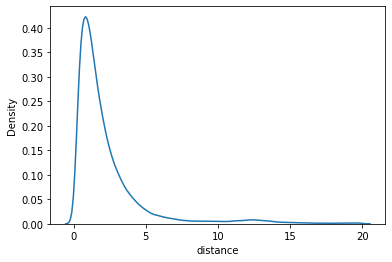

In [21]:
sns.kdeplot(data=df['distance'])

<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

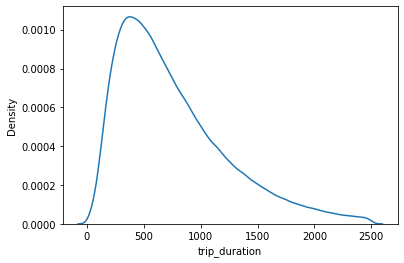

In [22]:
sns.kdeplot(data=df['trip_duration'])

* Both trip_duration and Distance are normally distributed (slightly right skewed)

## Pre-processing and Model building

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse

In [20]:
df_bkp=df
# Let's get categorical variables encoded
df=pd.get_dummies(df,columns=['vendor_id','passenger_count','store_and_fwd_flag','typeofday','window','pickup_month','pickup_dayofmonth'])

In [21]:
df.columns

Index(['trip_duration', 'distance', 'vendor_id_1', 'vendor_id_2',
       'passenger_count_0', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'typeofday_off', 'typeofday_on', 'window_busy', 'window_non-busy',
       'pickup_month_1', 'pickup_month_2', 'pickup_month_3', 'pickup_month_4',
       'pickup_month_5', 'pickup_month_6', 'pickup_dayofmonth_1',
       'pickup_dayofmonth_2', 'pickup_dayofmonth_3', 'pickup_dayofmonth_4',
       'pickup_dayofmonth_5', 'pickup_dayofmonth_6', 'pickup_dayofmonth_7',
       'pickup_dayofmonth_8', 'pickup_dayofmonth_9', 'pickup_dayofmonth_10',
       'pickup_dayofmonth_11', 'pickup_dayofmonth_12', 'pickup_dayofmonth_13',
       'pickup_dayofmonth_14', 'pickup_dayofmonth_15', 'pickup_dayofmonth_16',
       'pickup_dayofmonth_17', 'pickup_dayofmonth_18', 'pickup_dayofmonth_19',
       'pickup_dayofmonth_20', 'p

In [22]:
x=df.drop('trip_duration',axis=1)
y=df['trip_duration']

In [23]:
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=.3, random_state=48)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_train2,x_test2, y_train2, y_test2=train_test_split(x_train, y_train, test_size=.5, random_state=50)
print(x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape)

(487650, 53) (487650,) (208993, 53) (208993,)
(243825, 53) (243825,) (243825, 53) (243825,)


In [28]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import root as mse

modelLR=LR(normalize=True)
modelLR.fit(x_train2,y_train2)
train_pred=modelLR.predict(x_train2)
test_pred=modelLR.predict(x_test2)
train_score=np.sqrt(mse(train_pred, y_train2))
test_score=np.sqrt(mse(test_pred, y_test2))
print('Train score: ', train_score, '  Test score: ', test_score)

Train score:  373.05703665274063   Test score:  372.46951186443806


c:\users\owner\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Features', ylabel='coef'>

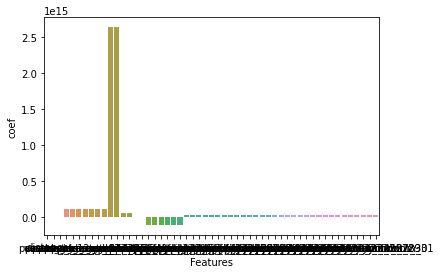

In [29]:
cf=pd.DataFrame({'Features':x.columns, 'coef':modelLR.coef_})
sns.barplot(cf['Features'],cf['coef'])

In [30]:
sig_vars=cf.loc[cf.coef>= .5, 'Features']
sig_vars

0                 distance
1              vendor_id_1
2              vendor_id_2
3        passenger_count_0
4        passenger_count_1
5        passenger_count_2
6        passenger_count_3
7        passenger_count_4
8        passenger_count_5
9        passenger_count_6
10    store_and_fwd_flag_N
11    store_and_fwd_flag_Y
12           typeofday_off
13            typeofday_on
14             window_busy
22     pickup_dayofmonth_1
23     pickup_dayofmonth_2
24     pickup_dayofmonth_3
25     pickup_dayofmonth_4
26     pickup_dayofmonth_5
27     pickup_dayofmonth_6
28     pickup_dayofmonth_7
29     pickup_dayofmonth_8
30     pickup_dayofmonth_9
31    pickup_dayofmonth_10
32    pickup_dayofmonth_11
33    pickup_dayofmonth_12
34    pickup_dayofmonth_13
35    pickup_dayofmonth_14
36    pickup_dayofmonth_15
37    pickup_dayofmonth_16
38    pickup_dayofmonth_17
39    pickup_dayofmonth_18
40    pickup_dayofmonth_19
41    pickup_dayofmonth_20
42    pickup_dayofmonth_21
43    pickup_dayofmonth_22
4

In [31]:
x_train2=x_train2[sig_vars]
x_train=x_train[sig_vars]
x_test2=x_test2[sig_vars]
x_test=x_test[sig_vars]

In [34]:
modelLR=LR(normalize=True)
modelLR.fit(x_train2,y_train2)
train_pred=modelLR.predict(x_train2)
test_pred=modelLR.predict(x_test2)
train_score=mse(train_pred, y_train2)
test_score=mse(test_pred, y_test2)
print('Train score: ', np.sqrt(train_score), '  Test score: ', np.sqrt(test_score))

Train score:  373.87491131490077   Test score:  373.26684919365925


In [35]:
residuals=pd.DataFrame({'Actual':y_test2, 'Predicted':test_pred,})
residuals['residual']=residuals['Actual']-residuals['Predicted']

(-500.0, 500.0)

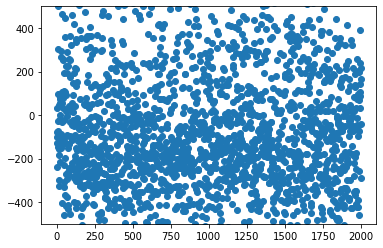

In [36]:
plt.scatter(y=residuals['residual'].iloc[0:2000], x=range(0,2000))
plt.ylim(-500,500)

* There is pattern and relation within residuals

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 1.1000e+01, 2.0000e+01,
        2.2000e+01, 3.1000e+01, 7.5000e+01, 1.4100e+02, 2.1700e+02,
        3.1100e+02, 4.5800e+02, 6.1600e+02, 8.3400e+02, 2.5320e+03,
        8.5270e+03, 1.8627e+04, 2.7464e+04, 3.0064e+04, 2.8007e+04,
        2.4309e+04, 2.0197e+04, 1.6511e+04, 1.3422e+04, 1.0828e+04,
        8.7520e+03, 6.9240e+03, 5.5430e+03, 4.3950e+03, 3.4170e+03,
        2.6830e+03, 2.1110e+03, 1.7060e+03, 1.3590e+03, 1.0500e+03,
        7.7200e+02, 6.4500e+02, 4.6100e+02, 3.1900e+02, 2.1300e+02,
        1.3300e+02, 7.6000e+01, 2.1000e+01, 7.0000e+00, 4.0000e+00]),
 array([-2205.25 , -2120.755, -2036.26 , -1951.765, -1867.27 , -1782.775,
        -1698.28 , -1613.785, -1529.29 , -1444.795, -1360.3  , -1275.805,
        -1191.31 , -1106.815, -1022.32 ,  -937.825,  -853.33 ,  -768.835,
         -684.34 ,  -599.845,  -515.35 ,  -430.855,  -346.36 ,  -261.865,
         -177.37 ,   -

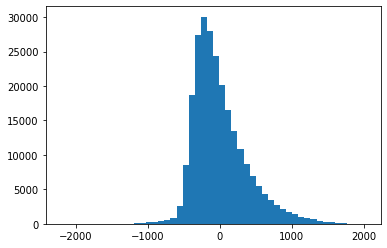

In [37]:
plt.hist(residuals.residual,bins=50)

* Residuals are normally distributed. So assumption holds true

<AxesSubplot:>

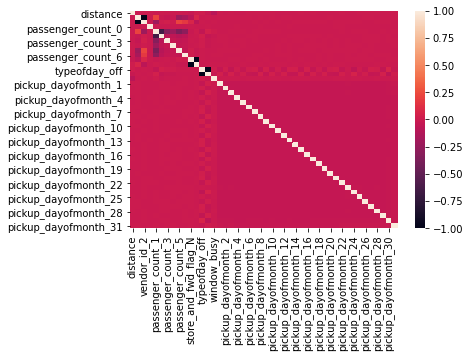

In [38]:
sns.heatmap(x_test2.corr())

* Heatmap shows there is no multicllinearity

#### Linear Regression

In [39]:
modelLR.fit(x_train2,y_train2)
train_pred=modelLR.predict(x_train2)
#test_pred=modelLR.predict(x_test)

In [41]:
test_pred=modelLR.predict(x_test)
train_score=np.sqrt(mse(t
                        
                        rain_pred,y_train2))
test_score=np.sqrt(mse(test_pred,y_test))

In [42]:
print('Train score: ',train_score, ' Test score: ', test_score)

Train score:  373.87491131490077  Test score:  375.51108900156004


#### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeRegressor as DT

# Running model for different max depths to understand the best fit

train_score=[]
test_score=[]
mx_dpth=[5, 8, 10, 12, 15, 18, 20]
for i in mx_dpth:
    model=DT(random_state=30, max_depth=i)
    model.fit(x_train, y_train)
    train_pred=model.predict(x_train)
    test_pred=model.predict(x_test)
    train_score.append(np.sqrt(mse(train_pred,y_train)))
    test_score.append(np.sqrt(mse(test_pred,y_test)))

Scores={'Max_Depth':mx_dpth, 'Train_Score':train_score, 'Test_Score':test_score}
print(pd.DataFrame(Scores))

   Max_Depth  Train_Score  Test_Score
0          5   343.369425  345.404630
1          8   339.830214  342.809362
2         10   338.135389  343.993998
3         12   334.719071  347.251150
4         15   325.777966  355.446777
5         18   311.981388  368.018514
6         20   300.723178  377.836295


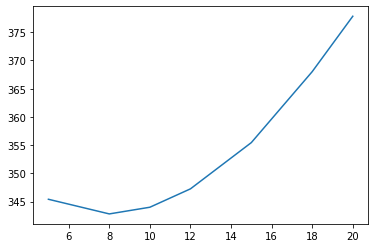

In [49]:
plt.plot(mx_dpth, test_score)

* As clearly seen the error follows elbow curve with increasing max depth parameter. We can say best performance is at Max depth 8

#### Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingRegressor as GB

model=GB(alpha=.001, n_estimators=35, max_depth=18)
model.fit(x_train, y_train)
train_pred=model.predict(x_train)
test_pred=model.predict(x_test)
train_score=np.sqrt(mse(train_pred, y_train))
test_score=np.sqrt(mse(test_pred, y_test))
print(train_score, ' ', test_score)

259.6760118451123   349.9438459507065


* We can ideally play around with different hyper parameter values to get the best result